# MNIST Classification with a Softmax Head
This notebook mirrors the LDA-based workflow, but uses a standard softmax classifier head on top of the encoder.


### Setup


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
tfm = transforms.ToTensor()
train_ds = datasets.MNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = datasets.MNIST(root='./data', train=False, transform=tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)


(60000, 10000)

### Model: encoder + softmax head


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Linear(64, dim),
        )

    def forward(self, x):
        return self.net(x)

class SoftmaxHead(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.linear = nn.Linear(D, C)

    def forward(self, z):
        return self.linear(z)

class DeepClassifier(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = SoftmaxHead(D, C)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

model = DeepClassifier(C=10, D=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, 16):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)

    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    print(f"[{epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")


[01] train loss=1.2549 acc=0.5517 | test acc=0.7159
[02] train loss=0.6422 acc=0.7937 | test acc=0.8526
[03] train loss=0.4643 acc=0.8861 | test acc=0.8996
[04] train loss=0.3555 acc=0.9152 | test acc=0.9133
[05] train loss=0.2801 acc=0.9311 | test acc=0.9237
[06] train loss=0.2362 acc=0.9411 | test acc=0.9208
[07] train loss=0.1981 acc=0.9492 | test acc=0.9334
[08] train loss=0.1711 acc=0.9542 | test acc=0.9311
[09] train loss=0.1450 acc=0.9605 | test acc=0.9398
[10] train loss=0.1230 acc=0.9667 | test acc=0.9399
[11] train loss=0.1061 acc=0.9699 | test acc=0.9453
[12] train loss=0.0927 acc=0.9736 | test acc=0.9458
[13] train loss=0.0788 acc=0.9771 | test acc=0.9447
[14] train loss=0.0675 acc=0.9808 | test acc=0.9474
[15] train loss=0.0596 acc=0.9830 | test acc=0.9441


In [6]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()


DeepClassifier(
  (encoder): Encoder(
    (net): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=256, bias=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=256, out_features=64, bias=True)
      (4): ReLU(inplace=True)
      (5): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (head): SoftmaxHead(
    (linear): Linear(in_features=2, out_features=10, bias=True)
  )
)

### Collect a Small Random Subset of Embeddings


In [7]:
emb_list, y_list = [], []
max_points = int(len(train_ld.dataset) * 0.05)

with torch.no_grad():
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        z = model.encoder(X)
        emb_list.append(z)
        y_list.append(y)
        if sum(t.shape[0] for t in emb_list) >= max_points:
            break

Z = torch.cat(emb_list, dim=0).cpu().numpy()[:max_points]
Y = torch.cat(y_list, dim=0).cpu().numpy()[:max_points]
Z.shape, Y.shape


((3000, 2), (3000,))

### Inspect Learned Classifier Weights


In [8]:
W = model.head.linear.weight.detach().cpu()
b = model.head.linear.bias.detach().cpu()
W.shape, b.shape


(torch.Size([10, 2]), torch.Size([10]))

### Visualise Embeddings


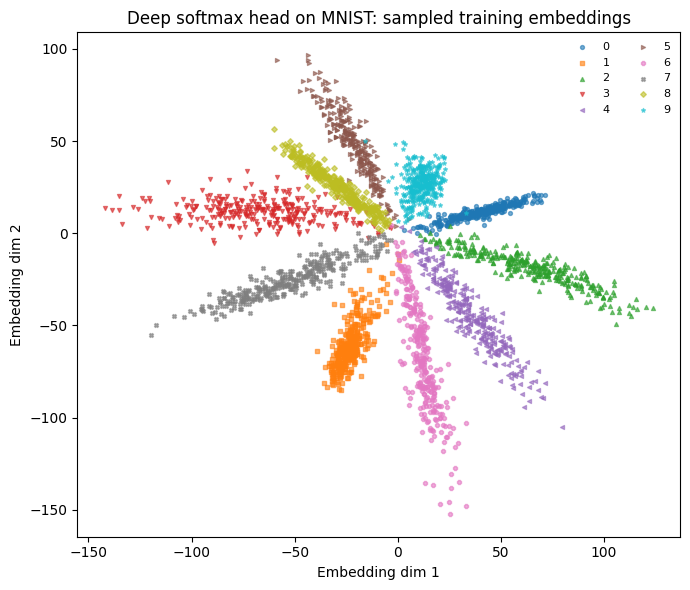

In [9]:
plt.figure(figsize=(7, 6))
cmap = plt.get_cmap("tab10", 10)
markers = ['o','s','^','v','<','>','P','X','D','*']

for c in range(10):
    idx = (Y == c)
    plt.scatter(Z[idx, 0], Z[idx, 1], s=8, alpha=0.6,
                c=[cmap(c)], marker=markers[c], label=f"{c}")

plt.title("Deep softmax head on MNIST: sampled training embeddings")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.legend(fontsize=8, ncol=2, frameon=False)
plt.tight_layout()
plt.show()
